### 스타벅스 매장 입지 분석
- 순서
    - [X] ~~데이터 수집~~
    - [ ] 데이터 전처리(다시)
    - [ ] 분석
    - [ ] 시각화

In [226]:
# 분석, 시각화 라이브러리 사용
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rcParams, rc, font_manager
import warnings
import seaborn as sns
import time
from tqdm import tqdm  # 반복 진행 프로그레스바 모듈
import folium
from folium.features import DivIcon         ## html로 텍스트표시할 아이콘 모듈
import json 

In [2]:
# 맷플롯립 한글 및 기타설정
## 맑은 고딕
font_path = 'C:/Windows/Fonts/malgun.ttf'
font_name = font_manager.FontProperties(fname=font_path).get_name() # Malgun Gothic
warnings.simplefilter('ignore') # 경고메시지 출력숨김

## 맷플롯립 설정
plt.rcParams['font.family'] = font_name # 폰트 설정
plt.rcParams['font.size'] = 12 # 글자크기
plt.rcParams['figure.figsize'] = (12, 6) # (W, H)
plt.rcParams['axes.grid'] = True # 차트 가로세로줄 표시
plt.rcParams['axes.unicode_minus'] = False # 한글설정 후 마이너스깨짐 방지

## 시본 설정
sns.set_theme(font=font_name, style='darkgrid', rc={'axes.unicode_minus':False})

#### 데이터 전처리
- 데이터 로드 후, 확인, 결측치나 이상치를 제거

In [4]:
## 스타벅스 서울매장정보 
## 인덱스 번호는 삭제할 것
df_seoul_starbuck = pd.read_csv('./data/스타벅스_서울매장정보_최종.csv', index_col=0)
df_seoul_starbuck.tail()

,매장코드,매장명,매장종류,주소,위도,경도
609,838,사가정역,general,서울특별시 중랑구 면목로 310,37.579594,127.087966
610,493,상봉역,general,서울특별시 중랑구 망우로 307 (상봉동),37.596890,127.086470
611,1668,묵동,general,"서울특별시 중랑구 동일로 952 (묵동, 로프트원 태릉입구역) 1층",37.615368,127.076633
612,2002,양원역,general,서울특별시 중랑구 양원역로10길 3 (망우동),37.606654,127.106360
613,1749,중화역,general,서울특별시 중랑구 봉화산로 35 1층,37.601709,127.078411


In [7]:
## 서울구별 위치 정보
df_seoul_municipality = pd.read_csv('./data/서울구별위치.csv', index_col=0)
df_seoul_municipality.tail()

,docity,do,city,longitude,latitude
20,서울용산구,서울,용산구,126.967522,37.536094
21,서울은평구,서울,은평구,126.931242,37.599969
22,서울종로구,서울,종로구,126.981642,37.570378
23,서울중구,서울,중구,126.999642,37.561003
24,서울중랑구,서울,중랑구,127.094778,37.603806


- 데이터 확인

In [8]:
## 결측치 확인(값이 빠져있는 것)
df_seoul_starbuck.info()

<class 'pandas.core.frame.DataFrame'>
Index: 614 entries, 0 to 613
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   매장코드    614 non-null    int64  
 1   매장명     614 non-null    object 
 2   매장종류    614 non-null    object 
 3   주소      614 non-null    object 
 4   위도      614 non-null    float64
 5   경도      614 non-null    float64
dtypes: float64(2), int64(1), object(3)
memory usage: 33.6+ KB


In [9]:
df_seoul_municipality.info()

<class 'pandas.core.frame.DataFrame'>
Index: 25 entries, 0 to 24
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   docity     25 non-null     object 
 1   do         25 non-null     object 
 2   city       25 non-null     object 
 3   longitude  25 non-null     float64
 4   latitude   25 non-null     float64
dtypes: float64(2), object(3)
memory usage: 1.2+ KB


#### 서울 행정구역 경계지도 Geojson(Geometry json 파일) 지도표시
- https://github.com/southkorea/seoul-maps

- 윈도우 Powershell로 다운로드
    - 터미널 새터미널로 오픈
    - day3/data로 이동 다음
    - wget -Uri https://raw.githubusercontent.com/southkorea/seoul-maps/master/kostat/2013/json/seoul_municipalities_geo_simple.json

- 깃헙에서 다운로드

#### 데이터전처리 계속


In [13]:
## 스타벅스 서울매장정보확인
df_seoul_starbuck.head()

,매장코드,매장명,매장종류,주소,위도,경도
0,1509,역삼아레나빌딩,general,서울특별시 강남구 언주로 425 (역삼동),37.501087,127.043069
1,1434,논현역사거리,general,서울특별시 강남구 강남대로 538 (논현동),37.510178,127.022223
2,1595,신사역성일빌딩,general,서울특별시 강남구 강남대로 584 (논현동),37.513931,127.020606
3,1527,국기원사거리,general,서울특별시 강남구 테헤란로 125 (역삼동),37.499517,127.031495
4,1468,대치재경빌딩,general,서울특별시 강남구 남부순환로 2947 (대치동),37.494668,127.062583


In [17]:
## 주소에서 '강남구' 따로 분리해서 새로운 컬럼을 생성
guList = []

for address in tqdm(df_seoul_starbuck['주소']):
    tmp_addr = address.split(' ')
    # print(tmp_addr[1]) # tmp_addr[1] 구별 이름
    guList.append(tmp_addr[1])

100%|██████████| 614/614 [00:00<00:00, 629043.15it/s]


In [18]:
len(guList)

614

In [19]:
## guList를 df_seoul_starbuck에 마지막 컬럼으로 추가
df_seoul_starbuck['구'] = guList

In [21]:
df_seoul_starbuck.tail()

,매장코드,매장명,매장종류,주소,위도,경도,구
609,838,사가정역,general,서울특별시 중랑구 면목로 310,37.579594,127.087966,중랑구
610,493,상봉역,general,서울특별시 중랑구 망우로 307 (상봉동),37.596890,127.086470,중랑구
611,1668,묵동,general,"서울특별시 중랑구 동일로 952 (묵동, 로프트원 태릉입구역) 1층",37.615368,127.076633,중랑구
612,2002,양원역,general,서울특별시 중랑구 양원역로10길 3 (망우동),37.606654,127.106360,중랑구
613,1749,중화역,general,서울특별시 중랑구 봉화산로 35 1층,37.601709,127.078411,중랑구


In [22]:
## 서울구별 위치값
df_seoul_municipality.tail()

,docity,do,city,longitude,latitude
20,서울용산구,서울,용산구,126.967522,37.536094
21,서울은평구,서울,은평구,126.931242,37.599969
22,서울종로구,서울,종로구,126.981642,37.570378
23,서울중구,서울,중구,126.999642,37.561003
24,서울중랑구,서울,중랑구,127.094778,37.603806


In [23]:
## docity컬럼 삭제, do=>시, city=>구, longi..=>경도, lati..=>위도
df_seoul_municipality = df_seoul_municipality[['do', 'city', 'latitude', 'longitude']]
df_seoul_municipality.tail()

,do,city,latitude,longitude
20,서울,용산구,37.536094,126.967522
21,서울,은평구,37.599969,126.931242
22,서울,종로구,37.570378,126.981642
23,서울,중구,37.561003,126.999642
24,서울,중랑구,37.603806,127.094778


In [24]:
## 이름변경
df_seoul_municipality.columns = ['시', '구', '위도', '경로']

In [25]:
df_seoul_municipality.tail()

,시,구,위도,경로
20,서울,용산구,37.536094,126.967522
21,서울,은평구,37.599969,126.931242
22,서울,종로구,37.570378,126.981642
23,서울,중구,37.561003,126.999642
24,서울,중랑구,37.603806,127.094778


#### 판다스 중급 기능
- 스타벅스 서울매장 정보를 구별로 통계(피벗)

In [28]:
## 스타벅스 매장에 구로 그룹화, 매장수 카운팅
## pivot_table 속성: values->어느값을 합칠래, index->어느값이 인덱스가 될래,
## aggfunc->합산을 함수는 뭔데(합, 갯수, 평균, 표준편차, 분산....)

## 아래의 결과는 메모리상에 결과이고, 하나의 변수에 할당해야함
df_seoul_starbuck.pivot_table(values='매장명', index='구', aggfunc='count').rename(columns={'매장명':'매장수'})

,매장수
구,
강남구,91
강동구,17
강북구,6
강서구,28
관악구,12
광진구,19
구로구,15
금천구,13
노원구,14


In [30]:
df_seoul_starbuck_count = df_seoul_starbuck.pivot_table(values='매장명', index='구', aggfunc='count').rename(columns={'매장명':'매장수'})
df_seoul_starbuck_count.tail()

,매장수
구,
용산구,24
은평구,14
종로구,39
중구,52
중랑구,8


In [31]:
df_seoul_starbuck_count.info()

<class 'pandas.core.frame.DataFrame'>
Index: 25 entries, 강남구 to 중랑구
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   매장수     25 non-null     int64
dtypes: int64(1)
memory usage: 400.0+ bytes


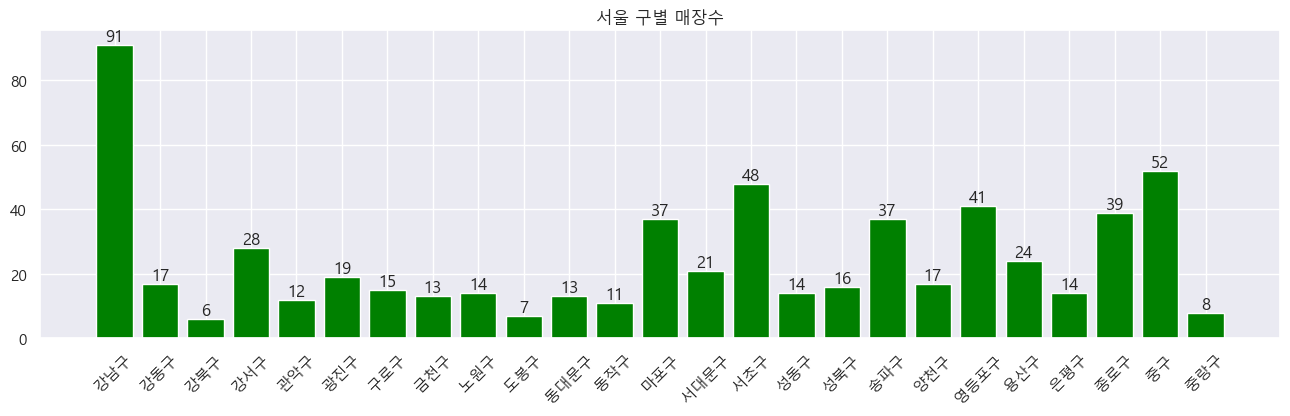

In [54]:
# 구별 매장정보를 차트화
plt.figure(figsize=(16, 4))
bar = plt.bar(df_seoul_starbuck_count.index, df_seoul_starbuck_count['매장수'], color='green')
# plt.summer()
plt.title('서울 구별 매장수')
plt.xticks(rotation=45)

for rect in bar: # 숫자 넣는 부분
    # 바차트 각 값별 높이 == 데이터 크기
    value = rect.get_height()    
    plt.text(rect.get_x() + rect.get_width()/2.0, value, f'{value:d}', ha='center', va='bottom', size = 12) # 바차트 정중앙에 텍스트를 표시

plt.show()

#### 서울시 인구 및 사업체 정보
- 서울열린데이터광장(https://data.seoul.go.kr/) 에서 다운로드 후 전처리
- 서울_구별인구정보, 서울_구별사업체정보.xlsx

In [60]:
## 서울 구별 인구데이터
df_seoul_population = pd.read_excel('./data/서울_구별인구정보.xlsx', header=0)
df_seoul_population.head()

,구,세대소계,성별소계,남자,여자,한국인소계,남자.1,여자.1,등록외국인소계,남자.2,여자.2,세대당인구,65세이상
0,소계,4469417,9638799,4649446,4989353,9386034,4540031,4846003,252765,109415,143350,2.10,1743696
1,종로구,72067,150453,71890,78563,139417,67306,72111,11036,4584,6452,1.93,28764
2,중구,64714,131793,63495,68298,121312,58659,62653,10481,4836,5645,1.87,25920
3,용산구,107825,227106,109826,117280,213151,102312,110839,13955,7514,6441,1.98,39747
4,성동구,133089,284766,137620,147146,277361,134519,142842,7405,3101,4304,2.08,49462


In [62]:
## 전체 소계만 삭제(drop) - 실행할때마다 0번 인덱스가 날아갈 수 있기 때문에 한번 실행
df_seoul_population.drop(0, inplace=True)

In [63]:
df_seoul_population.head()

,구,세대소계,성별소계,남자,여자,한국인소계,남자.1,여자.1,등록외국인소계,남자.2,여자.2,세대당인구,65세이상
1,종로구,72067,150453,71890,78563,139417,67306,72111,11036,4584,6452,1.93,28764
2,중구,64714,131793,63495,68298,121312,58659,62653,10481,4836,5645,1.87,25920
3,용산구,107825,227106,109826,117280,213151,102312,110839,13955,7514,6441,1.98,39747
4,성동구,133089,284766,137620,147146,277361,134519,142842,7405,3101,4304,2.08,49462
5,광진구,170077,351180,167562,183618,335554,161277,174277,15626,6285,9341,1.97,56819


In [64]:
df_seoul_population.tail()

,구,세대소계,성별소계,남자,여자,한국인소계,남자.1,여자.1,등록외국인소계,남자.2,여자.2,세대당인구,65세이상
21,관악구,284578,497883,249026,248857,481956,242651,239305,15927,6375,9552,1.69,85418
22,서초구,169884,412078,196391,215687,407664,194291,213373,4414,2100,2314,2.40,65661
23,강남구,239775,550282,262991,287291,544873,260520,284353,5409,2471,2938,2.27,86606
24,송파구,285927,660025,316981,343044,654166,314347,339819,5859,2634,3225,2.29,108894
25,강동구,203734,463318,226237,237081,459167,224423,234744,4151,1814,2337,2.25,82984


In [65]:
## 서울 구별 사업체 현황로드
df_seoul_business = pd.read_excel('./data/서울_구별사업체정보.xlsx')
df_seoul_business.head()

,구,소계,여성대표자,성별소계,남자,여자
0,소계,1188091,407948,5771226,3218529,2552697
1,종로구,48361,16563,275063,153210,121853
2,중구,70308,25794,386564,213782,172782
3,용산구,29680,10454,152605,84314,68291
4,성동구,41665,13447,203221,116978,86243


In [66]:
## 서울 구별 사업체도 소계를 삭제
df_seoul_business.drop(index=0, inplace=True)

In [67]:
df_seoul_business.head()

,구,소계,여성대표자,성별소계,남자,여자
1,종로구,48361,16563,275063,153210,121853
2,중구,70308,25794,386564,213782,172782
3,용산구,29680,10454,152605,84314,68291
4,성동구,41665,13447,203221,116978,86243
5,광진구,33706,12297,129707,71124,58583


In [68]:
df_seoul_business.tail()

,구,소계,여성대표자,성별소계,남자,여자
21,관악구,37915,13641,128417,68392,60025
22,서초구,71958,23066,487976,290084,197892
23,강남구,110007,35453,801419,447809,353610
24,송파구,74531,25400,400781,244588,156193
25,강동구,41660,15226,157465,83415,74050


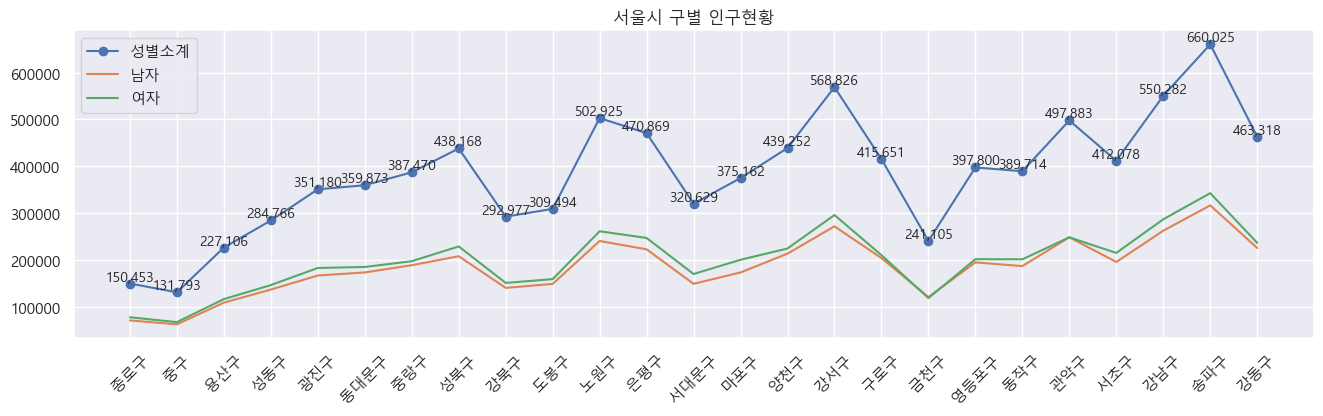

In [113]:
## 서울시 구별 인구 시각화
## df_seoul_population['구'] - x축
## df_seoul_population['성별소계'] - y축
plt.figure(figsize=(16, 4))
x = df_seoul_population['구'].to_list()
y = df_seoul_population['성별소계'].to_list()
plt.plot(x, y, label='성별소계', marker='o') # marker : o, ^, s, *
plt.plot(df_seoul_population['구'], df_seoul_population['남자'], label='남자')
plt.plot(df_seoul_population['구'], df_seoul_population['여자'], label='여자')

plt.xticks(rotation=45)
plt.legend()
plt.title('서울시 구별 인구현황')

# 숫자 넣는 부분, height + 0.25로 숫자 약간 위로 위치하게 조정
for i in range(len(x)):
    value = y[i]
    plt.text(x[i], value + 0.5, f'{value:,}', ha='center', va='bottom', size = 10)

plt.show()

In [114]:
## 서울구별 사업체 정보도 차트화 할 수 있음

In [115]:
## 서울시 구별 인구에서 성별소계만 추출
df_seoul_population[['구', '성별소계']]

,구,성별소계
1,종로구,150453
2,중구,131793
3,용산구,227106
4,성동구,284766
5,광진구,351180
6,동대문구,359873
7,중랑구,387470
8,성북구,438168
9,강북구,292977
10,도봉구,309494


In [117]:
## 스타벅스 서울 구별 정보 합치기(merge) == DB join
## merge에는 inplcce= 속성이 없음. 합친값을 다른 변수에 할당!
df_seoul_muni_and_pop = pd.merge(left=df_seoul_municipality, right=df_seoul_population[['구', '성별소계']], how='left', on='구')


In [121]:
df_seoul_muni_and_pop.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25 entries, 0 to 24
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   시       25 non-null     object 
 1   구       25 non-null     object 
 2   위도      25 non-null     float64
 3   경로      25 non-null     float64
 4   성별소계    25 non-null     int64  
dtypes: float64(2), int64(1), object(2)
memory usage: 1.1+ KB


In [120]:
df_seoul_muni_and_pop.head()

,시,구,위도,경로,성별소계
0,서울,강남구,37.514575,127.049556,550282
1,서울,강동구,37.527367,127.125864,463318
2,서울,강북구,37.636956,127.027719,292977
3,서울,강서구,37.548156,126.851675,568826
4,서울,관악구,37.475386,126.953844,497883


In [123]:
## innner 쓰지않고 left 쓰는 이유: 빈 열을 지우지않기 위해서
df_seoul_muni_and_pop_sbcount = pd.merge(left=df_seoul_muni_and_pop, right=df_seoul_starbuck_count, how='left', on='구')

In [124]:
df_seoul_muni_and_pop_sbcount.tail()

,시,구,위도,경로,성별소계,매장수
20,서울,용산구,37.536094,126.967522,227106,24
21,서울,은평구,37.599969,126.931242,470869,14
22,서울,종로구,37.570378,126.981642,150453,39
23,서울,중구,37.561003,126.999642,131793,52
24,서울,중랑구,37.603806,127.094778,387470,8


In [125]:
df_seoul_business.tail()

,구,소계,여성대표자,성별소계,남자,여자
21,관악구,37915,13641,128417,68392,60025
22,서초구,71958,23066,487976,290084,197892
23,강남구,110007,35453,801419,447809,353610
24,송파구,74531,25400,400781,244588,156193
25,강동구,41660,15226,157465,83415,74050


In [127]:
## 총 통계치
df_seoul_total = pd.merge(left=df_seoul_muni_and_pop_sbcount, right=df_seoul_business[['구', '소계', '성별소계']], how='left', on='구')

In [128]:
df_seoul_total.tail()

,시,구,위도,경로,성별소계_x,매장수,소계,성별소계_y
20,서울,용산구,37.536094,126.967522,227106,24,29680,152605
21,서울,은평구,37.599969,126.931242,470869,14,36509,109031
22,서울,종로구,37.570378,126.981642,150453,39,48361,275063
23,서울,중구,37.561003,126.999642,131793,52,70308,386564
24,서울,중랑구,37.603806,127.094778,387470,8,39310,113144


In [129]:
## 컬럼이름 변경
df_seoul_total.columns = ['시', '구', '위도', '경도', '인구수', '매장수', '사업체수', '사업체종사자수']

In [130]:
## 확인
df_seoul_total.head()

,시,구,위도,경도,인구수,매장수,사업체수,사업체종사자수
0,서울,강남구,37.514575,127.049556,550282,91,110007,801419
1,서울,강동구,37.527367,127.125864,463318,17,41660,157465
2,서울,강북구,37.636956,127.027719,292977,6,26385,80222
3,서울,강서구,37.548156,126.851675,568826,28,58806,290473
4,서울,관악구,37.475386,126.953844,497883,12,37915,128417


In [131]:
df_seoul_total.tail()

,시,구,위도,경도,인구수,매장수,사업체수,사업체종사자수
20,서울,용산구,37.536094,126.967522,227106,24,29680,152605
21,서울,은평구,37.599969,126.931242,470869,14,36509,109031
22,서울,종로구,37.570378,126.981642,150453,39,48361,275063
23,서울,중구,37.561003,126.999642,131793,52,70308,386564
24,서울,중랑구,37.603806,127.094778,387470,8,39310,113144


In [132]:
## 최종 DF csv 저장
df_seoul_total.to_csv('./data/서울구별_인구및사업체현황.csv')

#### 스타벅스 입지 분석, 지도 시각화

In [140]:
## 스타벅스 서울 매장 정보
df_seoul_starbuck.tail()

,매장코드,매장명,매장종류,주소,위도,경도,구
609,838,사가정역,general,서울특별시 중랑구 면목로 310,37.579594,127.087966,중랑구
610,493,상봉역,general,서울특별시 중랑구 망우로 307 (상봉동),37.596890,127.086470,중랑구
611,1668,묵동,general,"서울특별시 중랑구 동일로 952 (묵동, 로프트원 태릉입구역) 1층",37.615368,127.076633,중랑구
612,2002,양원역,general,서울특별시 중랑구 양원역로10길 3 (망우동),37.606654,127.106360,중랑구
613,1749,중화역,general,서울특별시 중랑구 봉화산로 35 1층,37.601709,127.078411,중랑구


In [160]:
## 지도 표시
seoul_center = [37.550800, 126.989857]  # ???
seoul_map = folium.Map(location=seoul_center, zoom_start=11)

## 각 매장별 위치, 지도에 마커로 표시, 614개 위치에 마커 표시
for idx in df_seoul_starbuck.index:
    lat = df_seoul_starbuck.loc[idx, '위도'] # 위도 DF.loc[행, 열]
    lng = df_seoul_starbuck.loc[idx, '경도'] # 경도
    # 마커표시
    # folium.CircleMarker(location=[lat, lng], color='green').add_to(seoul_map)
    popup_text = f'<strong style="font-size:13px;color:blue">{df_seoul_starbuck.loc[idx, "매장명"]}</strong><br/>{df_seoul_starbuck.loc[idx, "주소"]}'
    popup = folium.Popup(popup_text, max_width=500)
    folium.Marker(location=[lat, lng], color='green', popup=popup).add_to(seoul_map)

seoul_map

In [163]:
## 매장타입, 갯수를 뽑을때 pivot처럼 영구적으로 사용할 것이 아니면, value_counts()
df_seoul_starbuck['매장종류'].value_counts()

매장종류
general      555
reserve       34
generalDT     23
generalWT      2
Name: count, dtype: int64

#### 팁. VS Code에서 단축키 지정
- Ctrl + Shift + P(명령 프롬프트) > shortcut
    - Preference: Open Keyboard Shortcuts
    - 대문자, 소문자 키바인딩 입력

In [172]:
## 매장종류별 지도 시각화
seoul_center = [37.550800, 126.989857]  # ???
seoul_map = folium.Map(location=seoul_center, zoom_start=11)

## 각 매장별 위치를 지도 표시
for idx in df_seoul_starbuck.index:
    lat = df_seoul_starbuck.loc[idx, '위도'] # 위도 DF.loc[행, 열]
    lng = df_seoul_starbuck.loc[idx, '경도'] # 경도
    shop_name = df_seoul_starbuck.loc[idx, '매장명']
    shop_type = df_seoul_starbuck.loc[idx, '매장종류'] # general ~ generalWT까지 네가지

    popup_text = f'<strong style="font-size:13px;color:blue">{df_seoul_starbuck.loc[idx, "매장명"]}</strong><br/>{df_seoul_starbuck.loc[idx, "주소"]}'
    popup = folium.Popup(popup_text, max_width=500)

    ## 매장종류별로 서클마커 색상을 변경
    fill_color = ''
    if shop_type.upper() == 'GENERAL': fill_color = 'darkgreen'; size = 5
    elif shop_type.upper() == 'RESERVE': fill_color = 'black'; size = 8
    elif shop_type.upper() == 'GENERALDT': fill_color = 'blue'; size = 8
    elif shop_type.upper() == 'GENERALWT': fill_color = 'yellow'; size = 7

    # 서클마커
    ## popup은 그냥 글자만 입력하면 팝업이 세로로 나옴(보기 싫음)
    folium.CircleMarker(location=[lat, lng], popup=popup, fill=True, fill_color=fill_color, fill_opacity=1,
                        color='darkgreen', weight=1, radius=size).add_to(seoul_map)

seoul_map


- 실행결과

<img src="https://raw.githubusercontent.com/hugoMGSung/Iot-bigdata-2024/main/images/bda001.png" width="730">

#### 서울 구별 매장수 지도 시각화

In [174]:
df_seoul_total.tail()

,시,구,위도,경도,인구수,매장수,사업체수,사업체종사자수
20,서울,용산구,37.536094,126.967522,227106,24,29680,152605
21,서울,은평구,37.599969,126.931242,470869,14,36509,109031
22,서울,종로구,37.570378,126.981642,150453,39,48361,275063
23,서울,중구,37.561003,126.999642,131793,52,70308,386564
24,서울,중랑구,37.603806,127.094778,387470,8,39310,113144


In [177]:
## GEOJSON 서울 구별 경계값
path = './data/seoul_municipalities_geo_simple.json'
geojson = json.load(open(path, encoding='utf-8'))

In [182]:
## 이 외 geometry.coordinates 값으로 경계를 그림
geojson['features'][0]['properties']

{'code': '11250',
 'name': '강동구',
 'name_eng': 'Gangdong-gu',
 'base_year': '2013'}

In [207]:
## 스타일 지정 함수
def set_style(feature):
    return {
        'opacity': 0.8,   #선 투명
        'weight': 2,        # 선 두께
        'color': 'lightblue',   # 색상
        'fillOpacity': 0.2, # 채우기 투명도
        'dashArray': '5, 5' # 선 종류
    }

In [214]:
## 스타벅스 평균 매장수 계산. 구별로 평균을 냈을때 24.56이 나왔다
sb_mean = df_seoul_total['매장수'].mean()

In [223]:
## CartoDB.dark_matter는 경계표시를 눈에 잘보이게
seoul_map = folium.Map(location=seoul_center, zoom_start=11, tiles='CartoDB.dark_matter')

# 지역경계 표시
folium.GeoJson(geojson, style_function=set_style).add_to(seoul_map)

## 서울구별 정보를 지도 출력
for idx in df_seoul_total.index:
    lat = df_seoul_total.loc[idx, '위도']
    lng = df_seoul_total.loc[idx, '경도']
    count = df_seoul_total.loc[idx, '매장수']
    gu_name = df_seoul_total.loc[idx, '구']

    fill_color = ''
    if count > sb_mean: fill_color = 'darkred'
    else: fill_color = 'blue'

    popup_text = f'<strong style="font-size:13px;color:blue">{df_seoul_total.loc[idx, "구"]}</strong><br/>{count}개'
    popup = folium.Popup(popup_text, max_width=300)

    ## 구마다 서클마커 표시
    folium.CircleMarker(location=[lat, lng], popup=popup, 
                        color='yellow', fill_color=fill_color, fill_opacity=0.7,
                        weight=2, radius=count/2).add_to(seoul_map)

seoul_map

- 실행결과

<img src="https://raw.githubusercontent.com/hugoMGSung/Iot-bigdata-2024/main/images/bda002.png" width="730">

- 맷플롯립, 포리움 사용가능한 칼라맵
    - ['Greys', 'Purples', 'Blues', 'Greens', 'Oranges', 'Reds', 'YlOrBr', 'YlOrRd', 'OrRd', 'PuRd', 'RdPu', 'BuPu', 'GnBu', 'PuBu', 'YlGnBu', 'PuBuGn', 'BuGn', 'YlGn']
    - ['viridis', 'plasma', 'inferno', 'magma', 'cividis']                  

In [231]:
## 구별 스타벅스 매장수 지도 시각화(위의 지도 내용 그대로 사용)
seoul_map = folium.Map(location=seoul_center, zoom_start=11, tiles='CartoDB.dark_matter')

# 지역경계선 표시
folium.GeoJson(geojson, style_function=set_style).add_to(seoul_map)
# 지역경계별 색상
folium.Choropleth(geo_data=geojson, data=df_seoul_total, columns=['구', '매장수'], legend_name='구별 스타벅스 매장수',
                  fill_color='YlGnBu', fill_opacity=0.6, line_opacity=0.5, key_on='properties.name').add_to(seoul_map)

## 서울구별 정보를 지도 출력
for idx in df_seoul_total.index:
    lat = df_seoul_total.loc[idx, '위도']
    lng = df_seoul_total.loc[idx, '경도']
    count = df_seoul_total.loc[idx, '매장수']
    gu_name = df_seoul_total.loc[idx, '구']
    # DivIcon 클래스로 객체변수 생성
    icon = DivIcon(icon_size=(150, 60), icon_anchor=(75, 25), 
                   html=f''' 
                    <div style="font-size: 8pt; font-weight: bold; color:blue; text-align: center;">
                        {gu_name} / {count}개
                    </div>
                        ''')

    ## 구마다 마커 표시
    folium.Marker(location=[lat, lng], icon=icon).add_to(seoul_map)

seoul_map
## 구마다 색상을 표시. 매장수가 많으면 진하게 표시

- 실행결과

<img src="https://raw.githubusercontent.com/hugoMGSung/Iot-bigdata-2024/main/images/bda003.png" width="730">

In [237]:
## 구별 인구수 지도 시각화(위의 지도 내용 그대로 사용)
seoul_map = folium.Map(location=seoul_center, zoom_start=11, tiles='CartoDB.dark_matter')

# 지역경계선 표시
folium.GeoJson(geojson, style_function=set_style).add_to(seoul_map)
# 지역경계별 색상
folium.Choropleth(geo_data=geojson, data=df_seoul_total, columns=['구', '인구수'], legend_name='구별 인구수',
                  fill_color='YlGn', fill_opacity=0.6, line_opacity=0.5, key_on='properties.name').add_to(seoul_map)

## 서울구별 정보를 지도 출력
for idx in df_seoul_total.index:
    lat = df_seoul_total.loc[idx, '위도']
    lng = df_seoul_total.loc[idx, '경도']
    count = df_seoul_total.loc[idx, '인구수']
    gu_name = df_seoul_total.loc[idx, '구']
    # DivIcon 클래스로 객체변수 생성
    icon = DivIcon(icon_size=(150, 60), icon_anchor=(75, 25), 
                   html=f''' 
                    <div style="font-size: 8pt; font-weight: bold; color:blue; text-align: center;">
                        {gu_name} / {count:,}명
                    </div>
                        ''')

    ## 구마다 마커 표시
    folium.Marker(location=[lat, lng], icon=icon).add_to(seoul_map)

seoul_map
## 구마다 색상을 표시. 매장수가 많으면 진하게 표시

In [238]:
## 구별 사업체종사자수 지도 시각화(위의 지도 내용 그대로 사용)
seoul_map = folium.Map(location=seoul_center, zoom_start=11, tiles='CartoDB.dark_matter')

# 지역경계선 표시
folium.GeoJson(geojson, style_function=set_style).add_to(seoul_map)
# 지역경계별 색상
folium.Choropleth(geo_data=geojson, data=df_seoul_total, columns=['구', '사업체종사자수'], legend_name='구별 사업체종사자수',
                  fill_color='PuRd', fill_opacity=0.6, line_opacity=0.5, key_on='properties.name').add_to(seoul_map)

## 서울구별 정보를 지도 출력
for idx in df_seoul_total.index:
    lat = df_seoul_total.loc[idx, '위도']
    lng = df_seoul_total.loc[idx, '경도']
    count = df_seoul_total.loc[idx, '사업체종사자수']
    gu_name = df_seoul_total.loc[idx, '구']
    # DivIcon 클래스로 객체변수 생성
    icon = DivIcon(icon_size=(150, 60), icon_anchor=(75, 25), 
                   html=f''' 
                    <div style="font-size: 8pt; font-weight: bold; color:blue; text-align: center;">
                        {gu_name} / {count:,}명
                    </div>
                        ''')

    ## 구마다 마커 표시
    folium.Marker(location=[lat, lng], icon=icon).add_to(seoul_map)

seoul_map
## 구마다 색상을 표시. 매장수가 많으면 진하게 표시

#### 결론
- 사업체종사자수가 많은 곳에 스타벅스 매장이 많이 생긴다!!